# VQE of Hydrogen Molecule

The Variational Quantum Eigensolver (VQE), which is an optimization algorithm used to find the lowest energy state of a Hamiltonian, is a promising approach for near-term quantum hardware. In this tutorial, you will explore how to utilize hierarqcal with Qiskit for the algorithm. The focus will be on calculating the ground state energy of the $H_2$ molecule.

In [1]:
# !pip install qiskit[nature]
# !pip install --upgrade pyscf
# !pip install pennylane

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature import settings
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator
from qiskit.utils import algorithm_globals
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from hierarqcal import Qinit, Qcycle, Qunitary, Qmask, Qunmask
from qiskit import QuantumRegister, QuantumCircuit
from functools import partial, reduce
import pennylane as qml
import sympy
from qiskit.circuit import Parameter

seed = 170
algorithm_globals.random_seed = seed
settings.use_pauli_sum_op = False
np.random.seed(seed)

## Problem construction

Here we construct the hamiltonian of the $H_2$ molecule. The geometry of the molecule can be obtained from [NIST Chemistry WebBook](https://webbook.nist.gov/cgi/cbook.cgi?Name=hydrogen&Units=SI). We use the 6-31G basis set which leads to 4 spatial orbitals and requires 8 qubits.

In [3]:
driver = PySCFDriver(
    atom="H -0.0254 0.0000 0.0000; H 0.7174 0.0000 0.0000",
    basis="631g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()
mapper = ParityMapper()
qubit_op = mapper.map(problem.hamiltonian.second_q_op())

In [4]:
qubit_op.num_qubits, len(qubit_op)

(8, 185)

In [5]:
problem.num_spatial_orbitals

4

### Active space reduction

We select active space by specifying the number of electrons and spatial orbitals. This will select the active around the Fermi level. We limit ourselves to 2 spatials orbitals.

In [6]:
num_electrons = problem.num_particles
num_spatial_orbitals = problem.num_spatial_orbitals
num_spatial_orbitals = 2

transformer = transformer = ActiveSpaceTransformer(
    num_electrons=num_electrons,  # Number of electrons in our active space
    num_spatial_orbitals=
    num_spatial_orbitals,  # Number of orbitals in our active space
)

# Now you can get the reduced electronic structure problem
problem_reduced = transformer.transform(problem)

qubit_op_reduced = mapper.map(problem_reduced.hamiltonian.second_q_op())

In [7]:
num_qubits = qubit_op_reduced.num_qubits
num_qubits, len(qubit_op_reduced)

(4, 15)

The problem is now reduced to 4 qubits and 15 terms in the hamiltonian

In [8]:
qubit_op_reduced

SparsePauliOp(['IIII', 'IIZZ', 'IIIZ', 'IIZI', 'IZZI', 'IZZZ', 'ZXIX', 'IXZX', 'ZXZX', 'IXIX', 'ZZII', 'ZZIZ', 'IZIZ', 'ZZZZ', 'ZIZI'],
              coeffs=[-1.14131355+0.j, -0.01851164+0.j,  0.26294742+0.j,  0.08837872+0.j,
  0.26294742+0.j,  0.16229532+0.j,  0.02007481+0.j, -0.02007481+0.j,
 -0.02007481+0.j,  0.02007481+0.j, -0.01851164+0.j,  0.10845353+0.j,
  0.10845353+0.j,  0.09648216+0.j,  0.08837872+0.j])

## Classical Solution

As the problem at hand is relatively small, it can be solved exactly using classical methods. The code provided below utilizes the minimum eigensolver from the NumPy package to determine the ground state energy of the electronic system, measured in Hartree units. This exact solution will serve as a benchmark to evaluate the performance of the VQE algorithm.

In [9]:
numpy_solver = NumPyMinimumEigensolver()
calc = GroundStateEigensolver(mapper, numpy_solver)
res_actual = calc.solve(problem)

In [10]:
print(res_actual)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.864099028482
  - computed part:      -1.864099028482
~ Nuclear repulsion energy (Hartree): 0.712408738449
> Total ground state energy (Hartree): -1.151690290033
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.30769048  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [1.307690478199  0.0  0.0]
    - computed part:      [1.307690478199  0.0  0.0]
  > Dipole moment (a.u.): [0.000000001801  0.0  0.0]  Total: 0.000000001801
                 (debye): [0.000000004578  0.0  0.0]  Total: 0.000000004578
 


In [11]:
exact_energy = res_actual.eigenvalues[0]
exact_energy

-1.8640990284823584

Note that the VQE algorithm only has to reach to the `Electronic ground state energy (Hartree)`. 

## Ansatz contstruction

We construct the UCCSD ansatz from the paper [1]. First we construct the Hartree-Fock state.

In [12]:
num_particles = problem.num_particles

hf_state = HartreeFock(num_spatial_orbitals=num_spatial_orbitals,
                       num_particles=num_particles,
                       qubit_mapper=mapper)

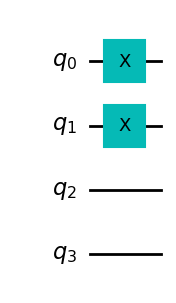

In [13]:
hf_state.draw('mpl')

With the help of PennyLane, we generate the `s_wires` and `p_wires` which serves as the input to UCCSD ansatz. More about it can be found on the [PennyLane's UCCSD Docs](https://docs.pennylane.ai/en/stable/code/api/pennylane.UCCSD.html)

In [14]:
# Generate single and double excitations
electrons = sum(problem.num_particles)
num_spin_orbitals = 2 * num_spatial_orbitals

singles, doubles = qml.qchem.excitations(electrons, num_spin_orbitals)

# Map excitations to the wires the UCCSD circuit will act on
s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

print("s_wires:", s_wires)
print("d_wires:", d_wires)

s_wires: [[0, 1, 2], [1, 2, 3]]
d_wires: [[[0, 1], [2, 3]]]


The UCCSD ansatz uses the Fermionic Single and Double Excication ansatzes. We create them below using **hierarqcal**, which is a tool designed to streamline quantum circuit construction, making it easier to design, compose, generate, scale, and manage circuit parameters.

In [15]:
def FermionicSingleExcitation(n_qubits, symbol_prefix='x'):

    # Motif to mask all qubits except outer two
    mask_middle = Qmask(global_pattern="0!0")
    unmask = Qunmask("previous")

    # Hadamard and Rx gate layer and reverse layer
    # Both take `inv` parameter to invert the rotation angle
    
    hrx_layer = lambda inv=False: mask_middle + Qcycle(mapping=Qunitary(
        "RX(x)^0;H()^1", symbols=[((-1)**inv) * np.pi / 2])) + unmask
    
    hrx_layer_r = lambda inv=False: mask_middle + Qcycle(mapping=Qunitary(
        "RX(x)^1;H()^0", symbols=[((-1)**inv) * np.pi / 2])) + unmask

    param = Parameter(f"{symbol_prefix}")  # Weight

    # Create ladder and reverse ladder motif
    cnot_ladder = Qcycle(mapping=Qunitary("CNOT()^01"), boundary="open")
    cnot_ladder_r = Qcycle(mapping=Qunitary("CNOT()^01"),
                           edge_order=[-1],
                           boundary="open")

    # Rz gate: takes `inv` parameter to invert the rotation angle
    rz_last = lambda inv: Qmask(
        "*1", mapping=Qunitary("Rz(x)^0", symbols=[
            ((-1)**inv) * param / 2
        ])) + Qunmask("previous")  # TODO replace with Qpivot once it's ready
    ladder = lambda inv=False: cnot_ladder + rz_last(inv) + cnot_ladder_r

    # Create excitation motifs
    excitation1 = hrx_layer(inv=True) + ladder() + hrx_layer()
    excitation2 = hrx_layer_r(inv=True) + ladder(inv=True) + hrx_layer_r()
    single_fermionic = excitation1 + excitation2
    hierq = Qinit(n_qubits) + single_fermionic

    # Convert the hierarchy to Qiskit Circuit and assign parameters
    circuit = hierq(backend="qiskit", barriers=False)
    return circuit

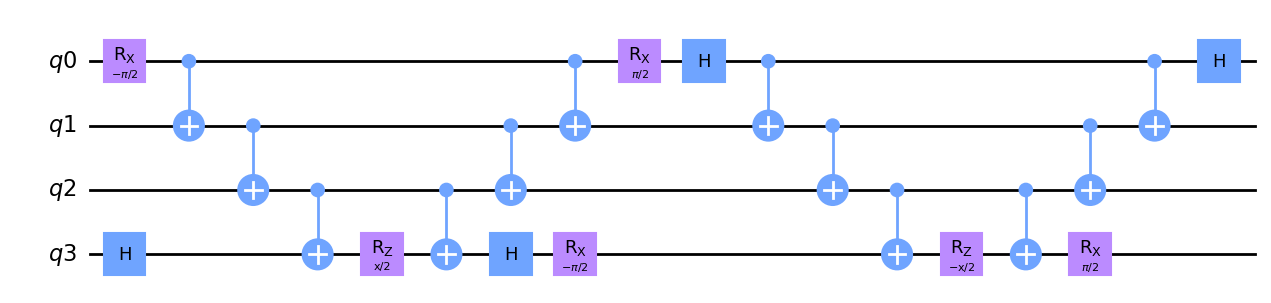

In [16]:
circuit = FermionicSingleExcitation(num_qubits, 'x')
circuit.draw("mpl")

In [17]:
def FermionicDoubleExcitation(n_qubits, qubits1, qubits2, symbol_prefix='x'):

    # The quantum circuit of FermionicDoubleExcitation applies single
    # qubit gates only on four qubits namely 's', 'r', 'q' and 'p' where
    # s < r < q < p. Therefore we extract those qubits and put them in
    # a list.
    s = qubits1[0]
    r = qubits1[-1]
    q = qubits2[0]
    p = qubits2[-1]
    indices = [s, r, q, p]

    # The list describes the qubits on which a Rx gate is applied
    # Each string in the list is of size 4 and the indices of string
    # represents the qubits 's', 'r', 'q' and 'p'. A '1' in the string
    # implies presence of Rx gate, whereas a '0' implies presence
    # Hadamard gate (as that is the only gate used along with Rx).
    # The other element of tuple denotes the sign for the weight
    # A 0 implies positive sign for the weight
    # A 1 implies negative sign for the weight
    # The first 4 layers have a positive sign
    # The later 4 layers have a negative sign
    r_locations = [("0010", 0), ("1011", 0), ("0111", 0), ("0001", 0),
                   ("1000", 1), ("0100", 1), ("1110", 1), ("1101", 1)]

    # Prepare masks
    # Masks are used to mask out the qubits so that an operation can
    # applied to specific qubits. We will need masks for all the 8
    # layers of the FermionicDoubleExcitation ansatz.
    layer_mask = Qmask("".join(
        ["0" if i in indices else "1" for i in range(n_qubits)]))
    cx_mask = Qmask("".join(
        ["0" if i in qubits1 + qubits2 else "1" for i in range(n_qubits)]))
    rz_mask = Qmask("".join(["0" if i == p else "1" for i in range(n_qubits)]))

    # Create hadamard and rx gate motifs
    hadamards = Qcycle(mapping=Qunitary("H()^0"), boundary="open")
    rx = lambda inv: Qunitary("RX(x)^0", symbols=[((-1)**inv) * np.pi / 2])
    hrx_layer = lambda r_loc, inv: layer_mask + Qmask(
        global_pattern=r_loc, mapping=rx(inv)) + hadamards + Qunmask("previous") * 2

    param = Parameter(f"{symbol_prefix}")  # Weight

    # CNOT and Inverse CNOT ladder
    def ladder(inv):
        cx_gate = Qcycle(mapping=Qunitary("CNOT()^01"), boundary="open")
        rz_gate = Qcycle(
            mapping=Qunitary("Rz(x)^0", symbols=[((-1)**inv) * param / 8]))
        cx_r_gate = Qcycle(mapping=Qunitary("CNOT()^01"),
                           edge_order=[-1],
                           boundary="open")

        cx = cx_mask + cx_gate + Qunmask("previous")
        rz_last = rz_mask + rz_gate + Qunmask(
            "previous")  # TODO replace with Qpivot once it's ready
        cx_r = cx_mask + cx_r_gate + Qunmask("previous")

        return cx + rz_last + cx_r

    excitations = [
        hrx_layer(r_loc, 1) + ladder(inv) + hrx_layer(r_loc, 0)
        for r_loc, inv in r_locations
    ]

    double_fermionic = reduce(lambda a, b: a + b, excitations)
    hierq = Qinit(n_qubits) + double_fermionic

    # Convert the hierarchy to Qiskit Circuit and assign parameters
    circuit = hierq(backend="qiskit", barriers=False)
    return circuit

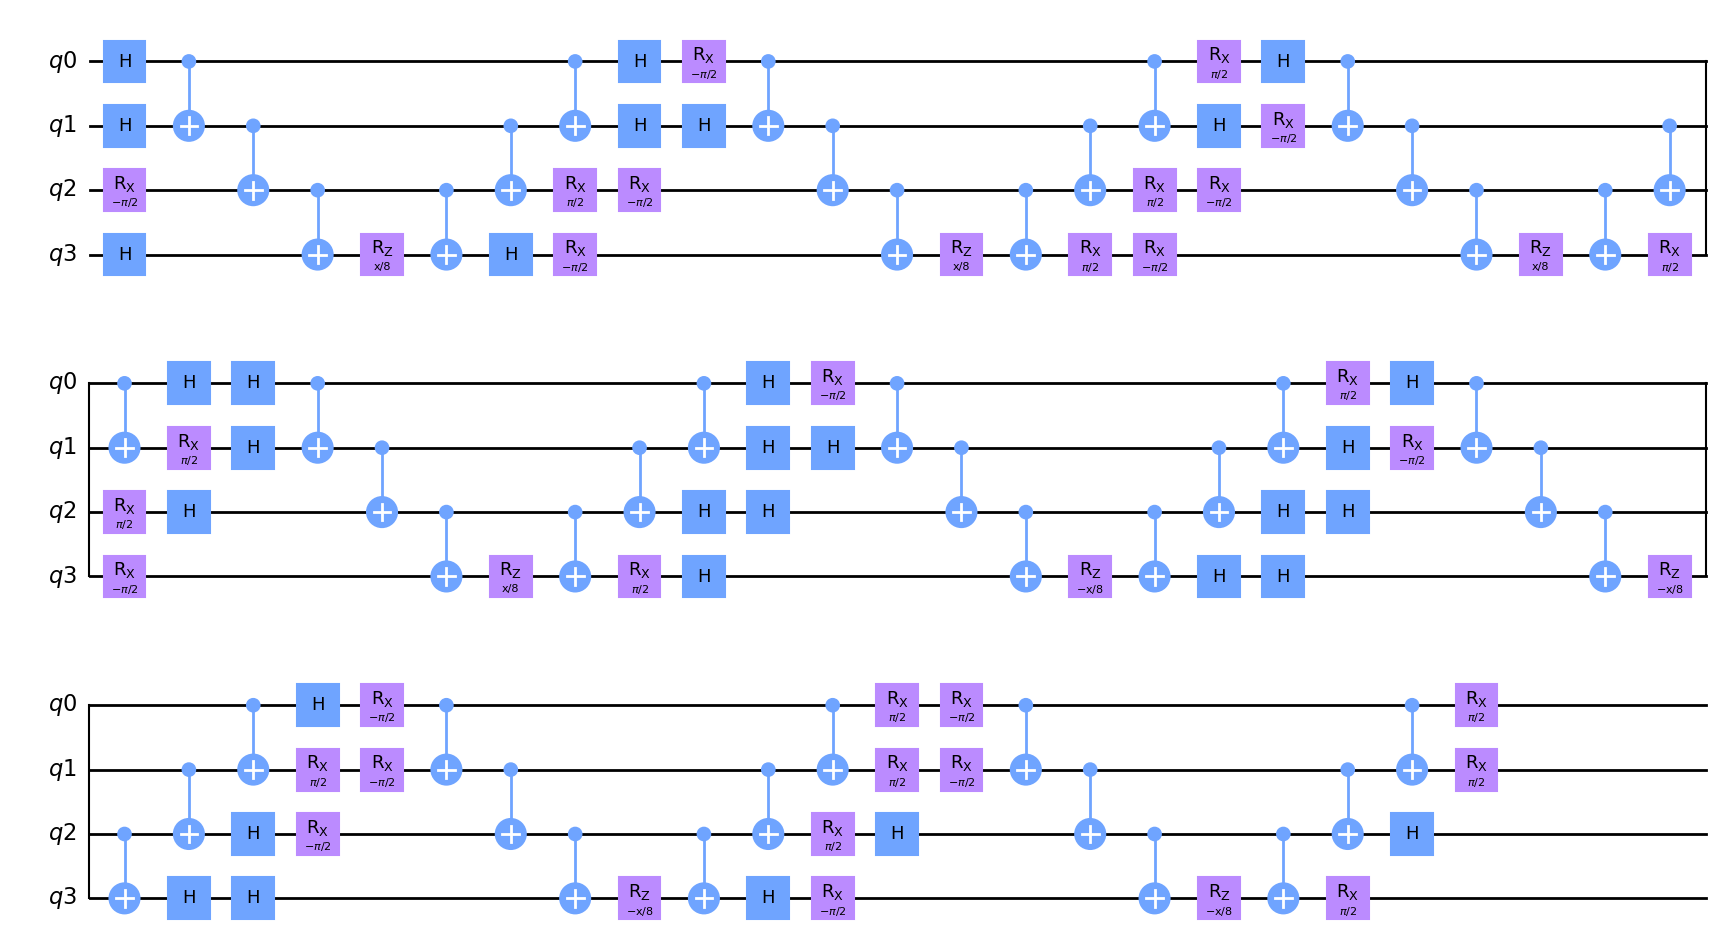

In [18]:
circuit = FermionicDoubleExcitation(num_qubits, d_wires[0][0], d_wires[0][1])
circuit.draw("mpl")

In [19]:
def UCCSD(n_qubits, s_qubits, d_qubits, init_state=None):
    circuit = QuantumCircuit(n_qubits)

    if init_state is not None:
        circuit.compose(init_state, inplace=True)
        circuit.barrier()

    for i, (qubits1, qubits2) in enumerate(d_wires):
        circuit.compose(FermionicDoubleExcitation(num_qubits, d_wires[0][0],
                                                  d_wires[0][1], f'θ_{i}'),
                        inplace=True)
        circuit.barrier()

    for j, s_qubits in enumerate(s_wires):
        circuit.compose(FermionicSingleExcitation(len(s_qubits), f'φ_{j}'),
                        qubits=s_qubits,
                        inplace=True)

        circuit.barrier()

    return circuit

In [20]:
ansatz = UCCSD(num_qubits, s_wires, d_wires, hf_state)

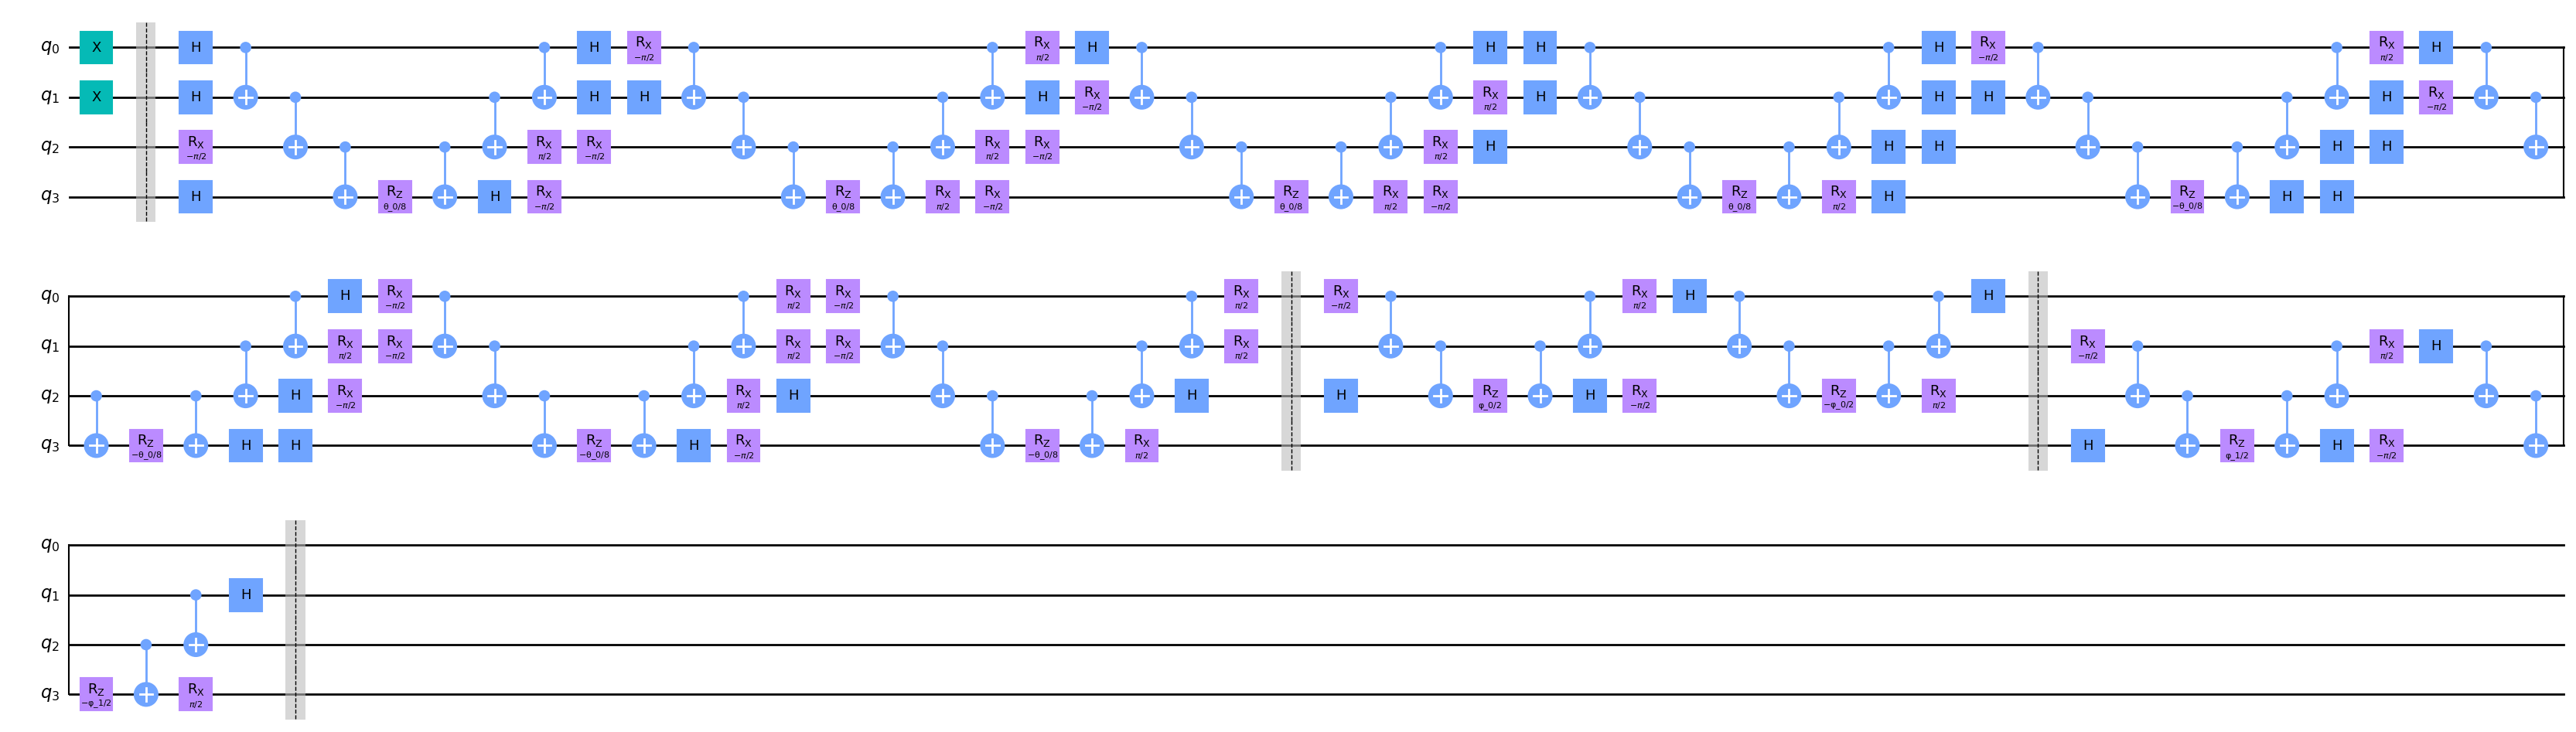

In [21]:
ansatz.draw('mpl', fold=50)

The number of parameters must match the total number of singles and doubles excitations

In [22]:
assert len(singles) + len(doubles) == ansatz.num_parameters

## Simulation

Using the VQE algorithm, we solve for the ground state energy of the $H_2$ molecule. We will use the `COBYLA` optimizer for 100 iterations

In [23]:
optimizer = COBYLA(maxiter=100)
estimator = Estimator()

In [24]:
intermediate_info = []


def callback(eval_count, parameters, value, std):
    intermediate_info.append(value)
    clear_output(wait=True)
    plt.plot(intermediate_info,
             color='purple',
             lw=2,
             label=f'Simulated VQE {np.round(value,4)}')
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=exact_energy,
                color="tab:red",
                ls="--",
                lw=2,
                label="Target: " + str(np.round(exact_energy, 4)))
    plt.legend()
    plt.grid()
    plt.show()

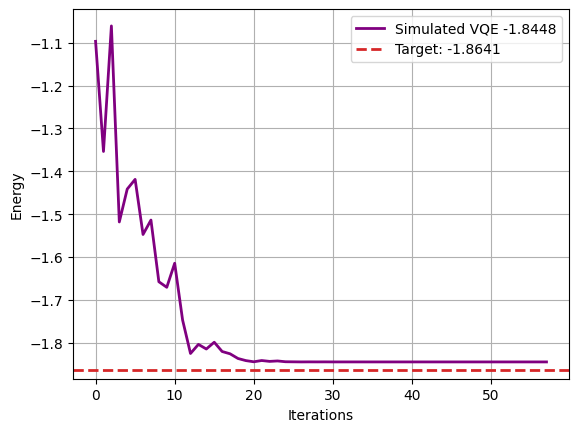

In [25]:
vqe = VQE(estimator, ansatz, optimizer, callback=callback)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_reduced)

In [26]:
interpreted_result = problem_reduced.interpret(result)
print(interpreted_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.844817105205
  - computed part:      -1.844817105205
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.712408738449
> Total ground state energy (Hartree): -1.132408366756
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.30769048  0.0  0.0]
 


In [27]:
def rel_err(target, measured):
    return abs((target - measured) / target)

In [28]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(res_actual.total_energies[0], interpreted_result.total_energies[0])

print(f'Expected ground state energy: {res_actual.total_energies[0]:.12f}')
print(f'Computed ground state energy: {interpreted_result.total_energies[0]:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -1.151690290033
Computed ground state energy: -1.132408366756
Relative error: 0.016742281709


## References

1. Barkoutsos, Panagiotis & Gonthier, Jérôme & Sokolov, Igor & Moll, Nikolaj & Salis, Gian & Fuhrer, Andreas & Ganzhorn, Marc & Egger, Daniel & Troyer, Matthias & Mezzacapo, Antonio & Filipp, Stefan & Tavernelli, Ivano. (2018). Quantum algorithms for electronic structure calculations: Particle-hole Hamiltonian and optimized wave-function expansions. Physical Review A. 98. 10.1103/PhysRevA.98.022322. 